# Auto Loan-Level Data Performance Analysis

#### Author: Barry Zihao Qie
#### Project Duration:: Dec 8th 2022 - Feb 2023

In [1]:
import os

path = os.getcwd()

print(path)

C:\Users\zihao\OneDrive\Desktop\Jupyter Notebook\Consumer ABS Jupyter Notebooks


In [2]:
os.chdir("C:\\Users\zihao\\OneDrive\\Desktop\\Citi Work\\ABS Research\\1010 XMLquery\\Autoloan Edgar Dataset")

path = os.getcwd()

print(path)

C:\Users\zihao\OneDrive\Desktop\Citi Work\ABS Research\1010 XMLquery\Autoloan Edgar Dataset


In [3]:
# imports
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates
import seaborn as sns
import py1010
import sys
from dateutil.relativedelta import relativedelta, FR

In [4]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [5]:
cur_month= datetime.now().replace(day=1).strftime(format="%#m/%Y")
prev_month = (datetime.now().replace(day=1) + relativedelta(months=-1)).strftime(format="%#m/%Y")
print(cur_month)
print(prev_month)

4/2023
3/2023


In [6]:
gateway  = "https://www2.1010data.com/cgi-bin/gw"
tablename = "pub.fin.efxas.client.v3.v3_panel_data"
username = "citi_zqie"
password = "Barry0228Qzh"

In [7]:
folder_path='C:\\Users\\zihao\\OneDrive\\Desktop\\Citi Work\\ABS Research\\1010 XMLquery\\Autoloan Edgar Dataset'

print(folder_path)

C:\Users\zihao\OneDrive\Desktop\Citi Work\ABS Research\1010 XMLquery\Autoloan Edgar Dataset


In [8]:
query_path = folder_path
files=os.listdir(query_path)
query_list=[]
for i in files:
    query_list.append(i)

print(len(query_list))
print(query_list)

7
['cdr_by Vintage.txt', 'cdr_vpr.txt', 'DQ state.txt', 'DQ state_by Vintage.txt', 'Mods joint Cure.txt', 'Mods.txt', 'Roll rate.txt']


In [9]:
from argparse import Namespace

settings = Namespace(
    
    #Chart Settings
    title_fontsize = 18,
    fig_size=(12,6),
    
    # BackUP Settings
    root_directory = "C:\\Users\\zihao\\OneDrive\\Desktop\\Citi Work\\ABS Research\\Auto Perf Output",
    report_directory = 'PythonChart_Content',
    backup_directory = 'BACKUP',
    
    #Chart Name Settings
    report_name = 'ExampleReport',
    rep_extn = ".png",
    backup_name_format = '%Y-%m-%d'
)

In [10]:
def Get_1010Data(q):
    session = py1010.Session(gateway,username,password,py1010.KILL)
    tablename = "pub.fin.efxas.client.v3.v3_panel_data"
    
    row_list = []
    headers = []
    try:
        query = session.query(tablename, q)
        query.run()
        for r in range(query.nrows):
            row_list.append(query.getrow(r))
        for c in query.cols:
            headers.append(c.name)
        
        df = pd.DataFrame(row_list,columns=headers)
        for col in df.columns:
            if isinstance(df[col][1],bytes):
                df[col] = df[col].str.decode("utf-8")
    
    except py1010.TentenException as e:
        print("Error: {}".format(e))
    
    session.close()
    print("result saved as a dataframe, and 1010 session closed")
    
    return df

In [11]:
def new_fmonth(df):
    for i in df['fmonth']:
        mon=i[0:2]
        year=i[3:6]
        df['new_fmonth'] = year+'/'+mon
    return df

In [12]:
def Get_DQ_pivot(df):
    df['fico_bucket']=df['fico_bucket'].astype('category')
    dq_hist = df.set_index(['fmonth','fico_bucket'])
    dq_hist['end_bal_fmonth_fico']=dq_hist.groupby(level=['fmonth','fico_bucket'])['end_bal'].sum()
    dq_hist['dq_percent'] = dq_hist['end_bal']/dq_hist['end_bal_fmonth_fico']
    dq_pivot = pd.pivot_table(dq_hist,values=['dq_percent'], columns = ['fmonth','fico_bucket','delinq_bucket'],aggfunc=[np.sum])
    return dq_pivot.transpose()

In [69]:
def Get_mods_pivot(df):
    df['fico_bucket']=df['fico_bucket'].astype('category')
    df = df.set_index(['fmonth','fico_bucket'])
    df['end_bal_fmonth_fico'] = df.groupby(level=['fmonth','fico_bucket'])['end_bal_sum'].sum()
    df['mod_percent'] = 100*(df['end_bal_sum']/df['end_bal_fmonth_fico'])
    df_pivot = pd.pivot_table(df,values=['mod_percent'],columns=['fmonth','fico_bucket','mod_flag'],aggfunc=[np.sum])
    return df_pivot.transpose()

In [92]:
def Get_cure_pivot(df):
    df['fico_bucket']=df['fico_bucket'].astype('category')
    df = df.set_index(['fmonth','fico_bucket'])
    df['end_bal_fmonth_fico'] = df.groupby(level=['fmonth','fico_bucket'])['end_bal'].sum()
    df['cure_percent'] = 100*(df['end_bal']/df['end_bal_fmonth_fico'])
    df_pivot = pd.pivot_table(df,values=['cure_percent'],columns=['fmonth','fico_bucket','cure_flag'],aggfunc=[np.sum])
    return df_pivot.transpose()

In [68]:
def Get_cure_overlapmods_pivot(df):
    df['fico_bucket']=df['fico_bucket'].astype('category')
    df = df.set_index(['fmonth','fico_bucket'])
    df['end_bal_fmonth_fico'] = df.groupby(level=['fmonth','fico_bucket'])['end_bal_sum'].sum()
    df['curemods_percent'] = 100*(df['end_bal_sum']/df['end_bal_fmonth_fico'])
    df_pivot = pd.pivot_table(df,values=['curemods_percent'],columns=['fmonth','fico_bucket','mod_joint_cure_flag'],aggfunc=[np.sum])
    return df_pivot.transpose()

In [16]:
def Get_DQ_pivot_byvintagefico(df):
    dq_hist = df.set_index(['seasoning','fico_bucket','vintage_bucket'])
    dq_hist['end_bal_fico_vintage']=dq_hist.groupby(level=['seasoning','vintage_bucket','fico_bucket'])['end_bal'].transform('sum')
    dq_hist['dq_percent'] = 100*(dq_hist['end_bal']/dq_hist['end_bal_fico_vintage'])
    dq_pivot = pd.pivot_table(dq_hist,values=['dq_percent'], columns = ['seasoning','vintage_bucket','fico_bucket','delinq_bucket'],aggfunc=[np.sum])
    return dq_pivot.transpose()

In [17]:
def Get_DQ_pivot_byvintage():
    dq_hist = df.set_index(['seasoning','vintage_bucket'])
    dq_hist['end_bal_vintage']=dq_hist.groupby(level=['seasoning','vintage_bucket'])['end_bal'].sum()
    dq_hist['dq_percent'] = 100*(dq_hist['end_bal']/dq_hist['end_bal_vintage'])
    dq_pivot = pd.pivot_table(dq_hist,values=['dq_percent'], columns = ['seasoning','vintage_bucket','delinq_bucket'],aggfunc=[np.sum])
    return dq_pivot.transpose()

In [18]:
def Get_3089_DQ(df):
    is_30_89_DQ = 'delinq_bucket ==["30~59 days delinq","60~89 days deilnq"]'
    result_set = df.query(is_30_89_DQ).groupby(level=['fmonth','fico_bucket'])['dq_percent'].sum()
    return result_set

In [19]:
def Get_roll_pivot(df):
    df['fico_bucket']=df['fico_bucket'].astype('category')
    df['initial_status'] = df['initial_status'].astype('category')
    df = df.set_index(['fmonth','fico_bucket','initial_status'])
    df['beg_bal_fmonth_fico'] = df.groupby(level=['fmonth','fico_bucket','initial_status'])['begin_bal'].sum()
    df['percent_of_begin_bal'] = df['begin_bal']/df['beg_bal_fmonth_fico'] 
    roll_pivot = pd.pivot_table(df,values=['begin_bal','percent_of_begin_bal'],columns=['fmonth','fico_bucket','initial_status','current_status'], aggfunc = [np.sum])
    return roll_pivot.transpose()

In [20]:
def filter_pivot(pivot_table,*criterion):
    for i in criterion:
        pivot_table = pivot_table.query(i)
    filtered_pt = pivot_table
    return filtered_pt

In [21]:
def datetime_convert(df):
    df['fmonth'] = pd.to_datetime(df['fmonth'].to_numpy(),yearfirst=True, format = "%Y%m")
    return df

In [22]:
def plot_metric_fullhist(metric_df,start_date,y_label,plottitle,*args):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    c = ['#002060','#00BDF2','#99ABC7','#CCF2FC','#99E2E3','#00B0B9','#FFD700','#A9561E','#E6DAA6']
    
    for i in range(0,len(args)):
        ax.plot(metric_df.loc[metric_df['fmonth']>=start_date].xs(args[i],level="fico_bucket")['fmonth'], metric_df.loc[metric_df['fmonth']>=start_date].xs(args[i],level="fico_bucket").iloc[:,-1],c=c[i],ls='-',label=args[i],fillstyle='none',linewidth = 4.0)
    
    ax.set_xticklabels([str(i) for i in metric_df['fmonth'].values], fontsize=15)
    ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)
    
    ax.tick_params(axis='x',colors='black')
    ax.tick_params(axis='y', colors='black')
    
    plt.xticks(rotation= 30)
    plt.ylabel(y_label,fontsize = 16)
    
    plt.legend(loc = "upper center", ncol = len(args), prop = {'size':16}, bbox_to_anchor = (0.5,1.1), fancybox =True, frameon = False)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3,9)))
                               
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))
                                 
    ax.grid(axis='y',linestyle='--',dashes=(5,5))
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
                                 
    ax.yaxis.set_ticks_position('none')
    plt.gca().spines['bottom'].set_color('gray')

    #plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,,.0f}'))
    fig.suptitle(plottitle,fontsize = 18)

    plt.show()
    
    return fig

In [36]:
def plot_metric_fullhist_vintage(metric_df,y_label,plottitle,*args):
    fig = plt.figure(figsize=(18,9))
    ax = fig.add_subplot(1,1,1)
    c = ['#002060','#00BDF2','#99ABC7','#CCF2FC','#99E2E3','#00B0B9','#FFD700','#A9561E','#E6DAA6']
    
    if 'fmonth' in metric_df.columns:
        for i in range(0,len(args)):
            ax.plot(metric_df.loc[metric_df['fmonth']>=start_date].xs(args[i],level="vintage_bucket")['fmonth'], metric_df.loc[metric_df['fmonth']>=start_date].xs(args[i],level="vintage_bucket").iloc[:,-1],c=c[i],ls='-',label=args[i],fillstyle='none',linewidth = 4.0)
        
        ax.set_xticklabels([str(i) for i in metric_df['fmonth'].values], fontsize=15)
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(2,8)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))               
                       
    elif 'seasoning' in metric_df.columns:
        for i in range(0,len(args)):
            ax.plot(metric_df.loc[metric_df['seasoning']>=0].xs(args[i],level="vintage_bucket")['seasoning'], metric_df.loc[metric_df['seasoning']>=0].xs(args[i],level="vintage_bucket").iloc[:,-1],c=c[i],ls='-',label=args[i],fillstyle='none',linewidth = 4.0)
        
        ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
        plt.xlabel('Seasoning',fontsize=16)
        plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,,.0f}'))
    
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,,.0f}'))
    
    ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)
    
    ax.tick_params(axis='x',colors='black')
    ax.tick_params(axis='y', colors='black')
    
    plt.xticks(rotation= 0)
    plt.ylabel(y_label,fontsize = 16)
    
    plt.legend(loc = "upper center", ncol = len(args), prop = {'size':16}, bbox_to_anchor = (0.5,1.1), fancybox =True, frameon = False)   
    ax.grid(axis='y',linestyle='--',dashes=(5,5))
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
                                 
    ax.yaxis.set_ticks_position('none')
    plt.gca().spines['bottom'].set_color('gray')                   
                       
    
    fig.suptitle(plottitle,fontsize = 18)                  
    
    return fig                   

In [37]:
def plot_metric_fullhist_vintage_y2decimals(metric_df,start_date,y_label,plottitle,*args):
    fig = plt.figure(figsize=(18,9))
    ax = fig.add_subplot(1,1,1)
    c = ['#002060','#00BDF2','#99ABC7','#CCF2FC','#99E2E3','#00B0B9','#FFD700','#A9561E','#E6DAA6']
    
    for i in range(0,len(args)):
        ax.plot(metric_df.loc[metric_df['seasoning']>=0].xs(args[i],level="vintage_bucket")['seasoning'], metric_df.loc[metric_df['seasoning']>=0].xs(args[i],level="vintage_bucket").iloc[:,-1],c=c[i],ls='-',label=args[i],fillstyle='none',linewidth = 4.0)
    
    ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
    ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)
    
    ax.tick_params(axis='x',colors='black')
    ax.tick_params(axis='y', colors='black')
    
    plt.xticks(rotation= 0)
    plt.ylabel(y_label,fontsize = 16)
    plt.xlabel('Seasoning',fontsize=16)
    
    plt.legend(loc = "upper center", ncol = len(args), prop = {'size':16}, bbox_to_anchor = (0.5,1.1), fancybox =True, frameon = False)   
    ax.grid(axis='y',linestyle='--',dashes=(5,5))
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
                                 
    ax.yaxis.set_ticks_position('none')
    plt.gca().spines['bottom'].set_color('gray')
    
    #plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,,.2f}'))
                       
    
    fig.suptitle(plottitle,fontsize = 18)                  
    
    return fig    

In [25]:
def save_chart(fig, figname):
    
    rep_path = os.path.join(settings.root_directory, settings.report_directory)
    if not os.path.exists(rep_path):
        os.makedirs(rep_path)
    
    filename = figname + settings.rep_extn
    fig.savefig(os.path.join(rep_path,filename))
    
    backup_path=os.path.join(rep_path, settings.backup_directory)     
    if not os.path.exists(backup_path):
        os.makedirs(backup_path)
    
    backup_date = datetime.today().strftime(settings.backup_name_format)
    backup_filename = figname + "_" + backup_date + settings.rep_extn
    fig.savefig(os.path.join(backup_path, backup_filename))
    
    print('chart saved to the target and BACKUP directory in this following directory C:\\Users\\zihao\\Desktop\\Citi Work\\ABS Research\\Auto Perf Output')

# ___MAIN___

In [75]:
start_date = input('What is the start date of your plot Specify to this format: 2018-03-01')

What is the start date of your plot Specify to this format: 2018-03-01 2018-03-01


In [76]:
print(start_date)
type(start_date)

2018-03-01


str

###  30 ~ 59 DQ, and 60 ~ 89 DQ

In [ ]:
file= open('DQ State.txt',"r")
lines = file.readlines()
q = [line.rstrip().lstrip() for line in lines]
file.close()
q="".join(q)

print(q)

In [ ]:
dq_state_hist = Get_1010Data(q)

In [ ]:
dq_state_hist = datetime_convert(dq_state_hist)

In [ ]:
dq_state_pivot = Get_DQ_pivot(dq_state_hist)
dq_state_pivot.tail(20)

In [ ]:
is_30_59_DQ = 'delinq_bucket == ["30~59 days delinq"]'
is_60_89_DQ = 'delinq_bucket == ["60~89 days delinq"]'

DQ30_59 = dq_state_pivot.query(is_30_59_DQ)
DQ60_69 = dq_state_pivot.query(is_60_89_DQ)

subprime_dq3059 = DQ30_59.query('fico_bucket == ["below 660"]')
nearprime_dq3059 = DQ30_59.query('fico_bucket == ["660-720"]')
prime_dq3059 = DQ30_59.query('fico_bucket == ["above 720"]')

subprime_dq6089 = DQ60_69.query('fico_bucket == ["below 660"]')
nearprime_dq6089 = DQ60_69.query('fico_bucket == ["660-720"]')
prime_dq6089 = DQ60_69.query('fico_bucket == ["above 720"]')

In [ ]:
subprime_dq3059=subprime_dq3059.reset_index(level=['fmonth'])
nearprime_dq3059=nearprime_dq3059.reset_index(level=['fmonth'])
prime_dq3059=prime_dq3059.reset_index(level=['fmonth'])

In [ ]:
subprime_dq3059.tail()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

c = ['#002060','#00BDF2','#99ABC7','#CCF2FC','99E2E3','#00B0B9','#FFD700','#A9561E','#E6DAA6']

ax1.plot(subprime_dq3059['fmonth'], subprime_dq3059['dq_percent']*100, c=c[0], ls='-', label = "below 660 (left axis)", fillstyle ='none', linewidth = 4.0)

plt.xticks(rotation =30)

ax1.set_xticklabels([str(i) for i in subprime_dq3059['fmonth'].values], fontsize=16)
ax1.set_yticklabels([str(i) for i in ax1.get_yticks()],fontsize=16)

ax1.tick_params(axis='x',colors='black')
ax1.tick_params(axis='y', colors='black')

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

ax1.grid(axis='y',linestyle='--',dashes=(5,5))
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.yaxis.set_ticks_position('none')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # no decimal place for y-ticks

# plot second axis
ax2 = ax1.twinx()

ax2.plot(nearprime_dq3059['fmonth'], nearprime_dq3059['dq_percent']*100, c=c[1], ls='-', label = "660-720 (right axis)", fillstyle ='none', linewidth = 4.0)
ax2.plot(prime_dq3059['fmonth'], prime_dq3059['dq_percent']*100, c=c[2], ls='-', label = "above 720 (right axis)", fillstyle ='none', linewidth = 4.0)

ax2.set_xticklabels([str(i) for i in prime_dq3059['fmonth'].values], fontsize=16)
ax2.set_yticklabels([str(i) for i in ax2.get_yticks()],fontsize=16)

ax2.tick_params(axis='x',colors='black')
ax2.tick_params(axis='y', colors='black')

ax2.yaxis.set_ticks_position('none')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(2,8)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

ax2.grid(axis='y',linestyle='--',dashes=(5,5))
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

# generate legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 'upper center', ncol = 3, prop = {'size':16},bbox_to_anchor=(0.5,1.1),fancybox=True,frameon=False)

plt.ylabel("% of Loan ending Balance", fontsize = 16)
plt.gca().spines['bottom'].set_color('grey')

fig.suptitle('Auto Loan 30~59 Days DQ by FICO bucket', fontsize = 18)

plt.show()

In [ ]:
DQ3959plot = fig
save_chart(DQ3959plot, "DQ 30-59 history")

In [ ]:
subprime_dq6089=subprime_dq6089.reset_index(level=['fmonth'])
nearprime_dq6089=nearprime_dq6089.reset_index(level=['fmonth'])
prime_dq6089=prime_dq6089.reset_index(level=['fmonth'])

In [ ]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

c = ['#002060','#00BDF2','#99ABC7','#CCF2FC','99E2E3','#00B0B9','#FFD700','#A9561E','#E6DAA6']

ax1.plot(subprime_dq6089['fmonth'], subprime_dq6089['dq_percent']*100, c=c[0], ls='-', label = "below 660 (left axis)", fillstyle ='none', linewidth = 4.0)

plt.xticks(rotation =30)

ax1.set_xticklabels([str(i) for i in subprime_dq6089['fmonth'].values], fontsize=16)
ax1.set_yticklabels([str(i) for i in ax1.get_yticks()],fontsize=16)

ax1.tick_params(axis='x',colors='black')
ax1.tick_params(axis='y', colors='black')

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

ax1.grid(axis='y',linestyle='--',dashes=(5,5))
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.yaxis.set_ticks_position('none')

#plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # no decimal place for y-ticks

# plot second axis
ax2 = ax1.twinx()

ax2.plot(nearprime_dq6089['fmonth'], nearprime_dq6089['dq_percent']*100, c=c[1], ls='-', label = "660-720 (right axis)", fillstyle ='none', linewidth = 4.0)
ax2.plot(prime_dq6089['fmonth'], prime_dq6089['dq_percent']*100, c=c[2], ls='-', label = "above 720 (right axis)", fillstyle ='none', linewidth = 4.0)

ax2.set_xticklabels([str(i) for i in prime_dq6089['fmonth'].values], fontsize=16)
ax2.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],fontsize=16)

ax2.tick_params(axis='x',colors='black')
ax2.tick_params(axis='y', colors='black')

ax2.yaxis.set_ticks_position('none')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(2,8)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

ax2.grid(axis='y',linestyle='--',dashes=(5,5))
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

# generate legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 'upper center', ncol = 3, prop = {'size':16},bbox_to_anchor=(0.5,1.1),fancybox=True,frameon=False)

plt.xticks(rotation=30)
plt.ylabel("% of Loan ending Balance", fontsize = 16)
plt.gca().spines['bottom'].set_color('grey')

fig.suptitle('Auto Loan 60~89 Days DQ by FICO bucket', fontsize = 18)

plt.show()

In [ ]:
DQ6089_plot = fig
save_chart(DQ6089_plot, "DQ 60-89 history")

### Seperator Line  ------------------------------Roll Analysis Starts Here ------------------------------------

In [ ]:
file= open('Roll rate.txt',"r")
lines = file.readlines()
q = [line.rstrip().lstrip() for line in lines]
file.close()
q="".join(q)

print(q)

In [ ]:
roll_hist = Get_1010Data(q)

In [ ]:
roll_hist = datetime_convert(roll_hist)
roll_hist.tail(10)

In [ ]:
# Define the criteria that will be used as a filter in pivot table as global variables

is_subprime = 'fico_bucket == ["below 660"]'
is_nearprime = 'fico_bucket == ["660-720"]'
is_prime = 'fico_bucket == ["above 720"]'

is_init_modcur = 'initial_status == ["current, modified"]'
is_init_notmod_cur = 'initial_status == ["current, not modified"]'
is_init_DQLT30 = 'initial_status == ["less than 30 delinq"]'
is_init_DQ30to59 = 'initial_status == ["30~59 days delinq"]'
is_init_DQ60to89 = 'initial_status == ["60~89 days delinq"]'
is_init_DQ90plus = 'initial_status == ["90 and above days delinq"]'

is_curr_modcur = 'current_status == ["current, modified"]'
is_curr_notmod_cur = 'current_status == ["current, not modified"]'
is_curr_DQLT30 = 'current_status == ["less than 30 delinq"]'
is_curr_DQ30to59 = 'current_status == ["30~59 days delinq"]'
is_curr_DQ60to89 = 'current_status == ["60~89 days delinq"]'
is_curr_DQ90plus = 'current_status == ["90 and above days delinq"]'
is_curr_default = 'current_status == ["default"]'
is_curr_paidoff = 'current_status == ["paid_off"]'

In [ ]:
roll_hist_masterpivot = Get_roll_pivot(roll_hist)
roll_hist_masterpivot['percent_of_begin_bal'] = roll_hist_masterpivot['percent_of_begin_bal']*100

In [ ]:
roll_hist_masterpivot.tail(25)

In [ ]:
#Define which subset of teh roll matrix we want to chart. Feed in the roll_hist_masterpivot as argument fo the function filter_pivot

curmod_stay = filter_pivot(roll_hist_masterpivot,is_init_modcur,is_curr_modcur).reset_index(level=['fmonth'])
notmod_cur_stay=filter_pivot(roll_hist_masterpivot,is_init_notmod_cur,is_curr_notmod_cur).reset_index(level=['fmonth'])

# current roll into other DQ category - by default we are talking about not modified current
cur_into_DQLT30 = filter_pivot(roll_hist_masterpivot,is_init_notmod_cur,is_curr_DQLT30).reset_index(level=['fmonth'])
cur_into_DQ30tot59 = filter_pivot(roll_hist_masterpivot,is_init_notmod_cur,is_curr_DQ30to59).reset_index(level=['fmonth'])
cur_intoDQ60to89 = filter_pivot(roll_hist_masterpivot,is_init_notmod_cur,is_curr_DQ60to89).reset_index(level=['fmonth'])                              
cur_into_DQ90plus=filter_pivot(roll_hist_masterpivot,is_init_notmod_cur,is_curr_DQ90plus).reset_index(level=['fmonth'])                         
cur_into_default=filter_pivot(roll_hist_masterpivot,is_init_notmod_cur,is_curr_default).reset_index(level=['fmonth'])
cur_into_paidoff=filter_pivot(roll_hist_masterpivot,is_init_notmod_cur,is_curr_paidoff).reset_index(level=['fmonth'])

DQ1to29_stay= filter_pivot(roll_hist_masterpivot,is_init_DQLT30,is_curr_DQLT30).reset_index(level=['fmonth'])
DQLT30_into_DQ30to59= filter_pivot(roll_hist_masterpivot,is_init_DQLT30,is_curr_DQ30to59).reset_index(level=['fmonth'])
DQLT30_into_DQ60to89= filter_pivot(roll_hist_masterpivot,is_init_DQLT30,is_curr_DQ60to89).reset_index(level=['fmonth'])
DQLT30_into_DQ90plus= filter_pivot(roll_hist_masterpivot,is_init_DQLT30,is_curr_DQ90plus).reset_index(level=['fmonth'])
DQLT30_into_modcur= filter_pivot(roll_hist_masterpivot,is_init_DQLT30,is_curr_modcur).reset_index(level=['fmonth'])
DQLT30_into_notmod_cur= filter_pivot(roll_hist_masterpivot,is_init_DQLT30,is_curr_notmod_cur).reset_index(level=['fmonth'])
DQLT30_into_default= filter_pivot(roll_hist_masterpivot,is_init_DQLT30,is_curr_default).reset_index(level=['fmonth'])
DQLT30_into_paidoff= filter_pivot(roll_hist_masterpivot,is_init_DQLT30,is_curr_paidoff).reset_index(level=['fmonth'])

DQ30to59_stay= filter_pivot(roll_hist_masterpivot,is_init_DQ30to59,is_curr_DQ30to59).reset_index(level=['fmonth'])
DQ30to59_into_DQ60to89= filter_pivot(roll_hist_masterpivot,is_init_DQ30to59,is_curr_DQ60to89).reset_index(level=['fmonth'])
DQ30to59_into_DQ90plus= filter_pivot(roll_hist_masterpivot,is_init_DQ30to59,is_curr_DQ90plus).reset_index(level=['fmonth'])
DQ30to59_into_DQLT30= filter_pivot(roll_hist_masterpivot,is_init_DQ30to59,is_curr_DQLT30).reset_index(level=['fmonth'])
DQ30to59_into_modcur= filter_pivot(roll_hist_masterpivot,is_init_DQ30to59,is_curr_modcur).reset_index(level=['fmonth'])
DQ30to59_into_notmod_cur= filter_pivot(roll_hist_masterpivot,is_init_DQ30to59,is_curr_notmod_cur).reset_index(level=['fmonth'])
DQ30to59_into_default =filter_pivot(roll_hist_masterpivot,is_init_DQ30to59,is_curr_default).reset_index(level=['fmonth'])
DQ30to59_into_paidoff =filter_pivot(roll_hist_masterpivot,is_init_DQ30to59,is_curr_paidoff).reset_index(level=['fmonth'])

DQ60to89_stay = filter_pivot(roll_hist_masterpivot,is_init_DQ60to89,is_curr_DQ60to89).reset_index(level=['fmonth'])
DQ60to89_into_DQLT30= filter_pivot(roll_hist_masterpivot,is_init_DQ60to89,is_curr_DQLT30).reset_index(level=['fmonth'])
DQ60to89_into_DQ30to59= filter_pivot(roll_hist_masterpivot,is_init_DQ60to89,is_curr_DQ30to59).reset_index(level=['fmonth'])
DQ60to89_into_DQ90plus= filter_pivot(roll_hist_masterpivot,is_init_DQ60to89,is_curr_DQ90plus).reset_index(level=['fmonth'])
DQ60to89_into_default= filter_pivot(roll_hist_masterpivot,is_init_DQ60to89,is_curr_default).reset_index(level=['fmonth'])
DQ60to89_into_modcur= filter_pivot(roll_hist_masterpivot,is_init_DQ60to89,is_curr_modcur).reset_index(level=['fmonth'])
DQ60to89_into_notmod_cur= filter_pivot(roll_hist_masterpivot,is_init_DQ60to89,is_curr_notmod_cur).reset_index(level=['fmonth'])

DQ90plus_stay= filter_pivot(roll_hist_masterpivot,is_init_DQ90plus,is_curr_DQ90plus).reset_index(level=['fmonth'])
DQ90plus_into_default= filter_pivot(roll_hist_masterpivot,is_init_DQ90plus,is_curr_default).reset_index(level=['fmonth'])
DQ90plus_into_DQ30to59= filter_pivot(roll_hist_masterpivot,is_init_DQ90plus,is_curr_DQ30to59).reset_index(level=['fmonth'])
DQ90plus_into_DQ60to89= filter_pivot(roll_hist_masterpivot,is_init_DQ90plus,is_curr_DQ60to89).reset_index(level=['fmonth'])
DQ90plus_into_DQLT30= filter_pivot(roll_hist_masterpivot,is_init_DQ90plus,is_curr_DQLT30).reset_index(level=['fmonth'])
DQ90plus_into_modcur= filter_pivot(roll_hist_masterpivot,is_init_DQ90plus,is_curr_modcur).reset_index(level=['fmonth'])
DQ90plus_into_notmod_cur= filter_pivot(roll_hist_masterpivot,is_init_DQ90plus,is_curr_notmod_cur).reset_index(level=['fmonth'])
DQ90plus_into_paidoff=filter_pivot(roll_hist_masterpivot,is_init_DQ90plus,is_curr_paidoff).reset_index(level=['fmonth'])

### Roll Rates Matrix

#### Not Modified Current Stays

In [ ]:
save_chart(
    plot_metric_fullhist(notmod_cur_stay,start_date,'% of Beginning Loan Balance','{Current, not modified} stays','below 660','660-720','above 720'),
    "not modified current stays")

#### Modified Current Stays

In [ ]:
save_chart(
    plot_metric_fullhist(curmod_stay,start_date,'% of Beginning Loan Balance','{Current, modified} stays','below 660','660-720','above 720'),
    "modified current stays")

#### Current (not mod) into 1~29 DQ

In [ ]:
save_chart(
    plot_metric_fullhist(cur_into_DQLT30,start_date,'% of Beginning Loan Balance','{Current} into {1~29 Days Delinquent}','below 660','660-720','above 720'),
    "Current roll into 1~29 DQ")

#### 1~29 DQ Stays

In [ ]:
save_chart(
    plot_metric_fullhist(DQ1to29_stay,start_date,'% of Beginning Loan Balance','{1~29 Days Delinquent} Stays','below 660','660-720','above 720'),
    "DQ 1~29 stays")

#### 1 ~ 29 DQ into 30~59 DQ

In [ ]:
save_chart(
    plot_metric_fullhist(DQLT30_into_DQ30to59,start_date,'% of Beginning Loan Balance','{1~29 Days Delinquent} into {30~59 Days Delinquent}','below 660','660-720','above 720'),
    "DQ 1~29 roll into DQ 30~59")

#### 1 ~ 29 DQ Cures to Current (not Mod)

In [ ]:
save_chart(
    plot_metric_fullhist(DQLT30_into_notmod_cur,start_date,'% of Beginning Loan Balance','{1~29 Days Delinquent} into {Current}','below 660','660-720','above 720'),
    "DQ 1~29 roll into Current")

#### 1 ~ 29 DQ into 60~89 DQ

In [ ]:
save_chart(
    plot_metric_fullhist(DQLT30_into_DQ60to89,start_date,'% of Beginning Loan Balance','{1~29 Days Delinquent} into {60~89 Days Delinquent}','below 660','660-720','above 720'),
    "DQ 1~29 roll into DQ 60~89")

#### 1 ~ 29 DQ into 60~89 DQ

In [ ]:
save_chart(
    plot_metric_fullhist(DQLT30_into_paidoff,start_date,'% of Beginning Loan Balance','{1~29 Days Delinquent} into {Paid Off}','below 660','660-720','above 720'),
    "DQ 1~29 roll into paidoff")

#### 30 ~ 59 DQ Stays

In [ ]:
save_chart(
    plot_metric_fullhist(DQ30to59_stay,start_date,'% of Beginning Loan Balance','{30~59 Days Delinquent} Stays','below 660','660-720','above 720'),
    "DQ 30~59 stays")

#### 30 ~ 59 DQ into 60~89 DQ

In [ ]:
save_chart(
    plot_metric_fullhist(DQ30to59_into_DQ60to89,start_date,'% of Beginning Loan Balance','{30~59 Days Delinquent} into {60~89 DAys Delinquent}','below 660','660-720','above 720'),
    "DQ 30~59 into DQ 60~89")

#### 30 ~ 59 DQ into 1~29 DQ

In [ ]:
save_chart(
    plot_metric_fullhist(DQ30to59_into_DQLT30,start_date,'% of Beginning Loan Balance','{30~59 Days Delinquent} into {1~29 DAys Delinquent}','below 660','660-720','above 720'),
    "DQ 30~59 into DQ 1~29")

#### 30 ~ 59 DQ into Current (not mod)

In [ ]:
save_chart(
    plot_metric_fullhist(DQ30to59_into_notmod_cur,start_date,'% of Beginning Loan Balance','{30~59 Days Delinquent} into {Current}','below 660','660-720','above 720'),
    "DQ 30~59 into Current")

#### 30 ~ 59 DQ into Paid off

In [ ]:
save_chart(
    plot_metric_fullhist(DQ30to59_into_paidoff,start_date,'% of Beginning Loan Balance','{30~59 Days Delinquent} into {Paid off}','below 660','660-720','above 720'),
    "DQ 30~59 into paid off")

#### 60 ~ 89 DQ Stays

In [ ]:
save_chart(
    plot_metric_fullhist(DQ60to89_stay,start_date,'% of Beginning Loan Balance','{60~89 Days Delinquent} Stays','below 660','660-720','above 720'),
    "DQ 60~89 stays")

#### 60 ~ 89 DQ into DQ 90+

In [ ]:
save_chart(
    plot_metric_fullhist(DQ60to89_into_DQ90plus,start_date,'% of Beginning Loan Balance','{60~89 Days Delinquent} into {90+ Days Delinquent}','below 660','660-720','above 720'),
    "DQ 60~89 into 90+ DQ")

#### 60 ~ 89 DQ into Default

In [ ]:
save_chart(
    plot_metric_fullhist(DQ60to89_into_default,start_date,'% of Beginning Loan Balance','{60~89 Days Delinquent} into {Default}','below 660','660-720','above 720'),
    "DQ 60~89 into default")

#### 60 ~ 89 DQ into 30~59 DQ

In [ ]:
save_chart(
    plot_metric_fullhist(DQ60to89_into_DQ30to59,start_date,'% of Beginning Loan Balance','{60~89 Days Delinquent} into {30~59 Days Delinquent}','below 660','660-720','above 720'),
    "DQ 60~89 into DQ 30~59")

#### 60 ~ 89 DQ into Current (not mod)

In [ ]:
save_chart(
    plot_metric_fullhist(DQ60to89_into_notmod_cur,start_date,'% of Beginning Loan Balance','{60~89 Days Delinquent} into {Current}','below 660','660-720','above 720'),
    "DQ 60~89 into Current")

#### DQ 90+ Stays

In [ ]:
save_chart(
    plot_metric_fullhist(DQ90plus_stay,start_date,'% of Beginning Loan Balance','{90+ Days Delinquent} Stays','below 660','660-720','above 720'),
    "DQ 90+ stays")

#### DQ 90+ into Default

In [ ]:
save_chart(
    plot_metric_fullhist(DQ90plus_into_default,start_date,'% of Beginning Loan Balance','{90+ Days Delinquent} into {Default}','below 660','660-720','above 720'),
    "DQ 90+ into Default")

#### DQ 90+ into DQ 60~89

In [ ]:
save_chart(
    plot_metric_fullhist(DQ90plus_into_DQ60to89,start_date,'% of Beginning Loan Balance','{90+ Days Delinquent} into {60~89 Days Delinquent}','below 660','660-720','above 720'),
    "DQ 90+ into DQ 60~89")

#### DQ 90+ into DQ 30~59

In [ ]:
save_chart(
    plot_metric_fullhist(DQ90plus_into_DQ30to59,start_date,'% of Beginning Loan Balance','{90+ Days Delinquent} into {30~59 Days Delinquent}','below 660','660-720','above 720'),
    "DQ 90+ into DQ 30~59")

#### DQ 90+ into Current (not mod)

In [ ]:
save_chart(
    plot_metric_fullhist(DQ90plus_into_notmod_cur,start_date,'% of Beginning Loan Balance','{90+ Days Delinquent} into {Current}','below 660','660-720','above 720'),
    "DQ 90+ into Current")

#### DQ 90+ into Paid-off

In [ ]:
save_chart(
    plot_metric_fullhist(DQ90plus_into_paidoff,start_date,'% of Beginning Loan Balance','{90+ Days Delinquent} into {Paidoff}','below 660','660-720','above 720'),
    "DQ 90+ into Paidoff")

#### ---- Roll into modified current from various DQ -----

#### DQ 30~59 cure into Modified Current

In [ ]:
save_chart(
    plot_metric_fullhist(DQ30to59_into_modcur,start_date,'% of Beginning Loan Balance','{30~59 Days Delinquent} into {Current, Modified}','below 660','660-720','above 720'),
    "DQ 30~59 into Modified Current")

#### DQ 60~89 cure into Modified Current

In [ ]:
save_chart(
    plot_metric_fullhist(DQ60to89_into_modcur,start_date,'% of Beginning Loan Balance','{60~89 Days Delinquent} into {Current, Modified}','below 660','660-720','above 720'),
    "DQ 60~89 into Modified Current")

#### DQ 90+ cure into Modified Current

In [ ]:
save_chart(
    plot_metric_fullhist(DQ90plus_into_modcur,start_date,'% of Beginning Loan Balance','{90+ Days Delinquent} into {Current, Modified}','below 660','660-720','above 720'),
    "DQ 90+ into Modified Current")

### Defaults and Payment Speed Analysis

In [ ]:
file = open('cdr_vpr.txt','r')
lines = file.readlines()
q = [line.rstrip().lstrip() for line in lines]
file.close()
q="".join(q)

print(q)

In [ ]:
otherperformance_hist = Get_1010Data(q)
otherperformance_hist = datetime_convert(otherperformance_hist)

In [ ]:
otherperformance_hist.tail(15)

In [ ]:
otherperformance_hist['cdr'] = (1-(1-otherperformance_hist['def_bal']/otherperformance_hist['begin_bal'])**12)*100
otherperformance_hist['vpr'] = (1-(1-(otherperformance_hist['prepay_bal']+otherperformance_hist['curtail_bal'])/otherperformance_hist['begin_bal'])**12)*100

In [ ]:
otherperformance_hist.tail(15)

In [ ]:
otherperformance_hist['fico_bucket'] = otherperformance_hist['fico_bucket'].astype('category')
otherperformance_pivot=pd.pivot_table(otherperformance_hist,values=['cdr','vpr'],columns=['fmonth','fico_bucket'],aggfunc=[np.sum]).transpose()

otherperformance_pivot = otherperformance_pivot.reset_index(level=['fmonth'])

In [ ]:
pd.concat([otherperformance_pivot.head(10),otherperformance_pivot.tail(10)])

### cdr History

In [ ]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

c = ['#002060','#00BDF2','#99ABC7','#CCF2FC','99E2E3','#00B0B9','#FFD700','#A9561E','#E6DAA6']

ax1.plot(otherperformance_pivot[['fmonth','cdr']].loc[otherperformance_pivot['fmonth']>=start_date].xs('below 660',level='fico_bucket')['fmonth'],
         otherperformance_pivot[['fmonth','cdr']].loc[otherperformance_pivot['fmonth']>=start_date].xs('below 660',level='fico_bucket')['cdr'],
         c=c[0], ls='-', label = "below 660 (left axis)", fillstyle ='none', linewidth = 4.0)

plt.xticks(rotation=30)

ax1.set_xticklabels([str(i) for i in otherperformance_pivot['fmonth'].values], fontsize=16)
ax1.set_yticklabels([str(i) for i in ax1.get_yticks()],fontsize=16)

ax1.tick_params(axis='x',colors='black')
ax1.tick_params(axis='y', colors='black')

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

ax1.grid(axis='y',linestyle='--',dashes=(5,5))
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.yaxis.set_ticks_position('none')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # no decimal place for y-ticks

# plot second axis
ax2 = ax1.twinx()

ax2.plot(otherperformance_pivot[['fmonth','cdr']].loc[otherperformance_pivot['fmonth']>=start_date].xs('660-720',level='fico_bucket')['fmonth'],
         otherperformance_pivot[['fmonth','cdr']].loc[otherperformance_pivot['fmonth']>=start_date].xs('660-720',level='fico_bucket')['cdr'],
         c=c[1], ls='-', label = "660-720 (right axis)", fillstyle ='none', linewidth = 4.0)

ax2.plot(otherperformance_pivot[['fmonth','cdr']].loc[otherperformance_pivot['fmonth']>=start_date].xs('above 720',level='fico_bucket')['fmonth'],
         otherperformance_pivot[['fmonth','cdr']].loc[otherperformance_pivot['fmonth']>=start_date].xs('above 720',level='fico_bucket')['cdr'],
         c=c[2], ls='-', label = "above 720 (right axis)", fillstyle ='none', linewidth = 4.0)

ax2.set_xticklabels([str(i) for i in otherperformance_pivot['fmonth'].values], fontsize=16)
ax2.set_yticklabels([str(i) for i in ax2.get_yticks()],fontsize=16)

ax2.tick_params(axis='x',colors='black')
ax2.tick_params(axis='y', colors='black')

ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.yaxis.set_ticks_position('none')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3,9)))

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

ax2.grid(axis='y',linestyle='--',dashes=(5,5))


# generate legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 'upper center', ncol = 3, prop = {'size':16},bbox_to_anchor=(0.5,1.1),fancybox=True,frameon=False)

plt.ylabel("CDR", fontsize = 16)
plt.gca().spines['bottom'].set_color('grey')

#fig.suptitle('Auto Loan 60~89 Days DQ by FICO bucket', fontsize = 18)

plt.show()

In [ ]:
cdr_chart = fig

In [ ]:
save_chart(cdr_chart,'CDR')

### VPR History

In [ ]:
save_chart(
    plot_metric_fullhist(otherperformance_pivot[['fmonth','vpr']],start_date,'VPR','','below 660','660-720','above 720'),
    'VPR'
)

### DQ State by Vintage Analysis

In [26]:
file = open('DQ state_by Vintage.txt','r')
lines = file.readlines()
q = [line.rstrip().lstrip() for line in lines]
file.close()
q="".join(q)

print(q)

<note type="base">Applied to table: pub.fin.edgar.auto_loan.loan_detail</note><base table="pub.fin.edgar.auto_loan.loan_detail"/><sel value="(credit_score>300)"/><willbe name="drop_record_flag" value="iff((zero_bal_code=NA) & (dq_status=NA);1;0)"/><note type="user"> Create a flag called drop_record which assigns a value of 1 to 1oan records whose zero_balance_code and dq_status are both blank,i.e.NA,andassign a value of 0 otherwise. </note><sel value="drop_record_flag=0"/><willbe name="fico_bucket" value="iff(credit_score<=660;'below 660';credit_score<=720; '660-720' ;credit_score<=800; 'above 720';'no fico')"/><willbe name="delinq_bucket" value="iff(zero_bal_code=4;'default';zero_bal_code='1' '2' '3' '5';'paid_off';dq_status=0;'current';dq_status<30;'less than 30 delinq';dq_status<60;'30~59 days delinq';dq_status<90;'60~89 days delinq';'90 and above days delinq')" label="delinquency bucket"/><willbe name="vintage_year" value="year(orig_dt)"/><willbe name="vintage_month" value="month(o

In [27]:
dq_state_byvintage = Get_1010Data(q)

result saved as a dataframe, and 1010 session closed


In [28]:
dq_state_byvintage.head(10)

,seasoning,fico_bucket,vintage_bucket,delinq_bucket,end_bal
0,-1,660-720,"1H,2021",current,0.0
1,-1,660-720,"1H,2022",current,0.0
2,-1,660-720,"2021,2H",current,0.0
3,-1,660-720,"2022,2H",current,0.0
4,-1,above 720,"1H,2021",current,0.0
5,-1,above 720,"1H,2022",current,0.0
6,-1,above 720,"2021,2H",current,0.0
7,-1,above 720,"2022,2H",current,0.0
8,-1,below 660,"1H,2021",current,0.0
9,-1,below 660,"1H,2022",current,0.0


In [29]:
len(dq_state_byvintage)

6378

In [30]:
dq_state_byvintage_pivot = Get_DQ_pivot_byvintagefico(dq_state_byvintage)

In [31]:
dq_state_byvintage_pivot = dq_state_byvintage_pivot.rename(index={'1H,2019':'2019,1H','1H,2020':'2020,1H','1H,2021': '2021,1H','1H,2022': '2022,1H'})

In [32]:
#pd.concat([dq_state_byvintage_pivot.head(15),dq_state_byvintage_pivot.tail(15)])

In [46]:
subprime_DQ30to59_byvintage = filter_pivot(dq_state_byvintage_pivot,'delinq_bucket == ["30~59 days delinq"]','fico_bucket == ["below 660"]').reset_index(level=['seasoning'])
nearprime_DQ30to59_byvintage = filter_pivot(dq_state_byvintage_pivot,'delinq_bucket == ["30~59 days delinq"]','fico_bucket == ["660-720"]').reset_index(level=['seasoning'])
prime_DQ30to59_byvintage = filter_pivot(dq_state_byvintage_pivot,'delinq_bucket == ["30~59 days delinq"]','fico_bucket == ["above 720"]').reset_index(level=['seasoning'])

subprime_DQ60to89_byvintage = filter_pivot(dq_state_byvintage_pivot,'delinq_bucket == ["60~89 days delinq"]','fico_bucket == ["below 660"]').reset_index(level=['seasoning'])
nearprime_DQ60to89_byvintage = filter_pivot(dq_state_byvintage_pivot,'delinq_bucket == ["60~89 days delinq"]','fico_bucket == ["660-720"]').reset_index(level=['seasoning'])
prime_DQ60to89_byvintage = filter_pivot(dq_state_byvintage_pivot,'delinq_bucket == ["60~89 days delinq"]','fico_bucket == ["above 720"]').reset_index(level=['seasoning'])

subprime_DQ90p_byvintage = filter_pivot(dq_state_byvintage_pivot,'delinq_bucket == ["90 and above days delinq"]','fico_bucket == ["below 660"]').reset_index(level=['seasoning'])
nearprime_DQ90p_byvintage = filter_pivot(dq_state_byvintage_pivot,'delinq_bucket == ["90 and above days delinq"]','fico_bucket == ["660-720"]').reset_index(level=['seasoning'])
prime_DQ90p_byvintage = filter_pivot(dq_state_byvintage_pivot,'delinq_bucket == ["90 and above days delinq"]','fico_bucket == ["above 720"]').reset_index(level=['seasoning'])

### Below 660 FICO, DQ 30~59 by Vintage

In [ ]:
pd.concat([subprime_DQ30to59_byvintage.head(30),subprime_DQ30to59_byvintage.tail(10)])

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2440077505.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2440077505.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


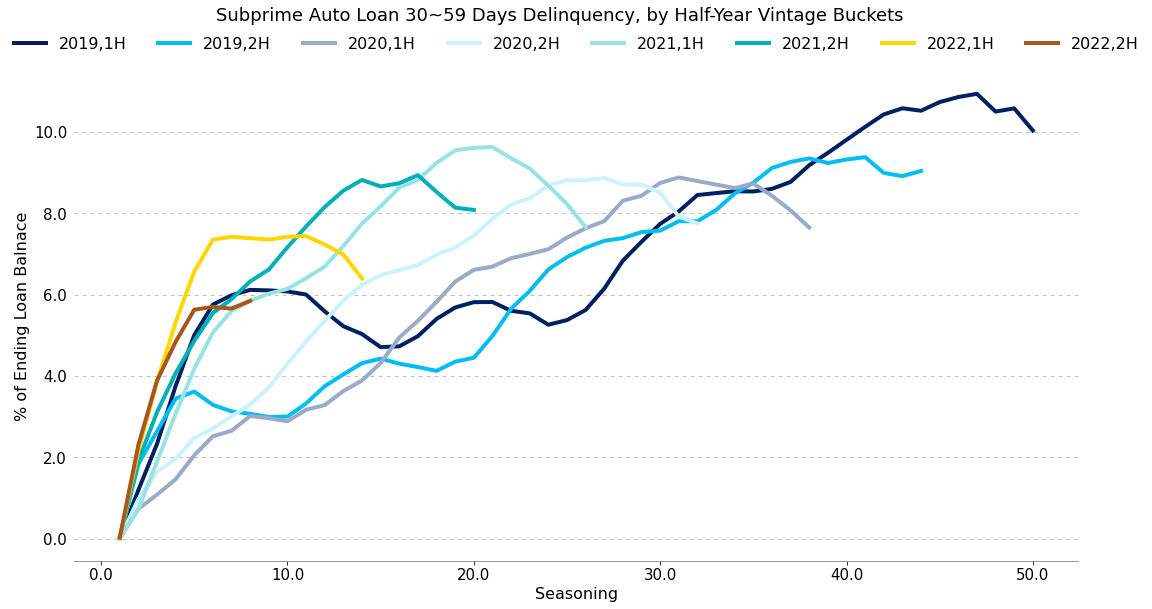

In [38]:
save_chart(
    plot_metric_fullhist_vintage(subprime_DQ30to59_byvintage,'% of Ending Loan Balnace','Subprime Auto Loan 30~59 Days Delinquency, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'DQ 30~59 by Vintage for FICO below 660'
)

### 660-720 FICO, DQ 30~59 by Vintage

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2440077505.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2440077505.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


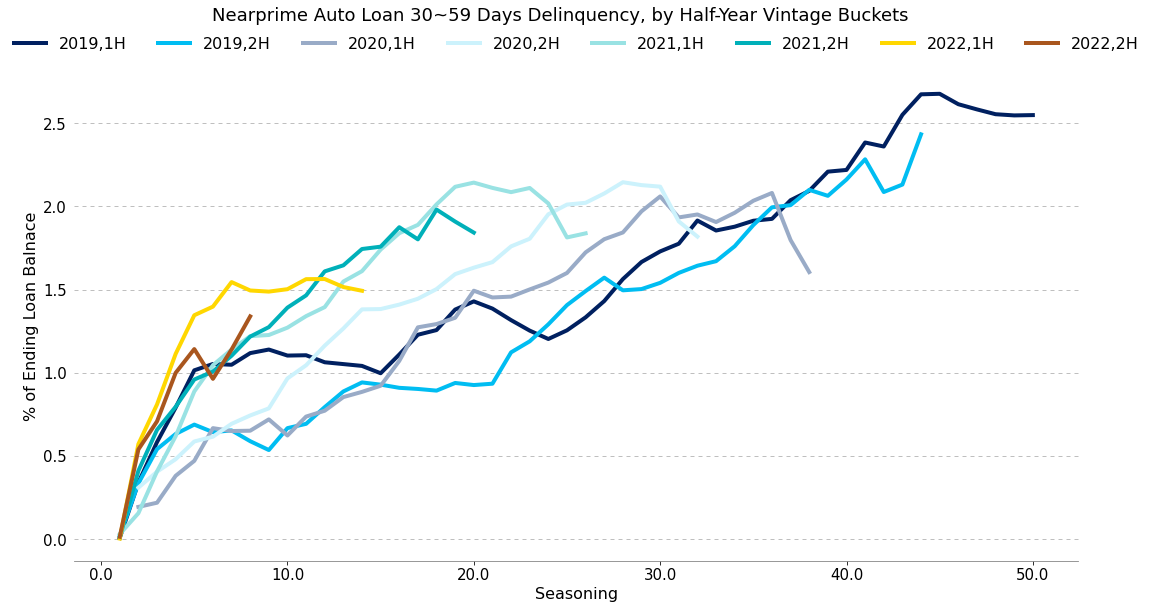

In [39]:
save_chart(
    plot_metric_fullhist_vintage(nearprime_DQ30to59_byvintage,'% of Ending Loan Balnace','Nearprime Auto Loan 30~59 Days Delinquency, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'DQ 30~59 by Vintage for FICO 660-720')

### Above 720 FICO, DQ 30~59 by Vintage

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


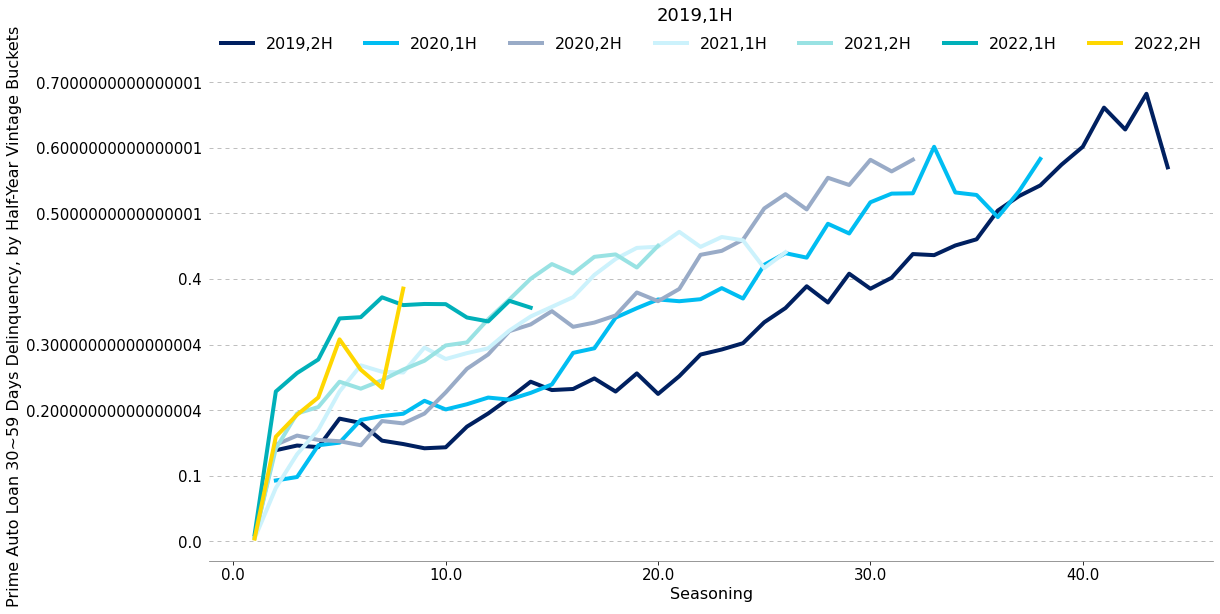

In [40]:
save_chart(
    plot_metric_fullhist_vintage_y2decimals(prime_DQ30to59_byvintage,'% of Ending Loan Balnace','Prime Auto Loan 30~59 Days Delinquency, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'DQ 30~59 by Vintage for FICO above 720')

### Below 660 FICO, DQ 60~89 DQ

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


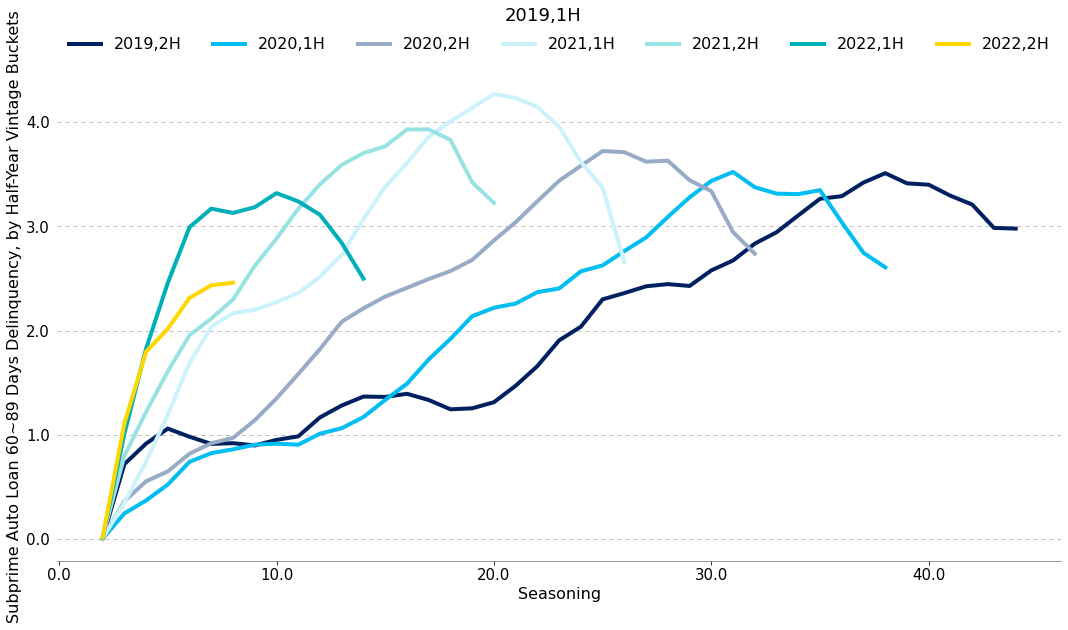

In [41]:
save_chart(
    plot_metric_fullhist_vintage_y2decimals(subprime_DQ60to89_byvintage,'% of Ending Loan Balnace','Subprime Auto Loan 60~89 Days Delinquency, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'DQ 60~89 by Vintage for FICO below 660')

### 660-720 FICO, DQ 60~89 DQ

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


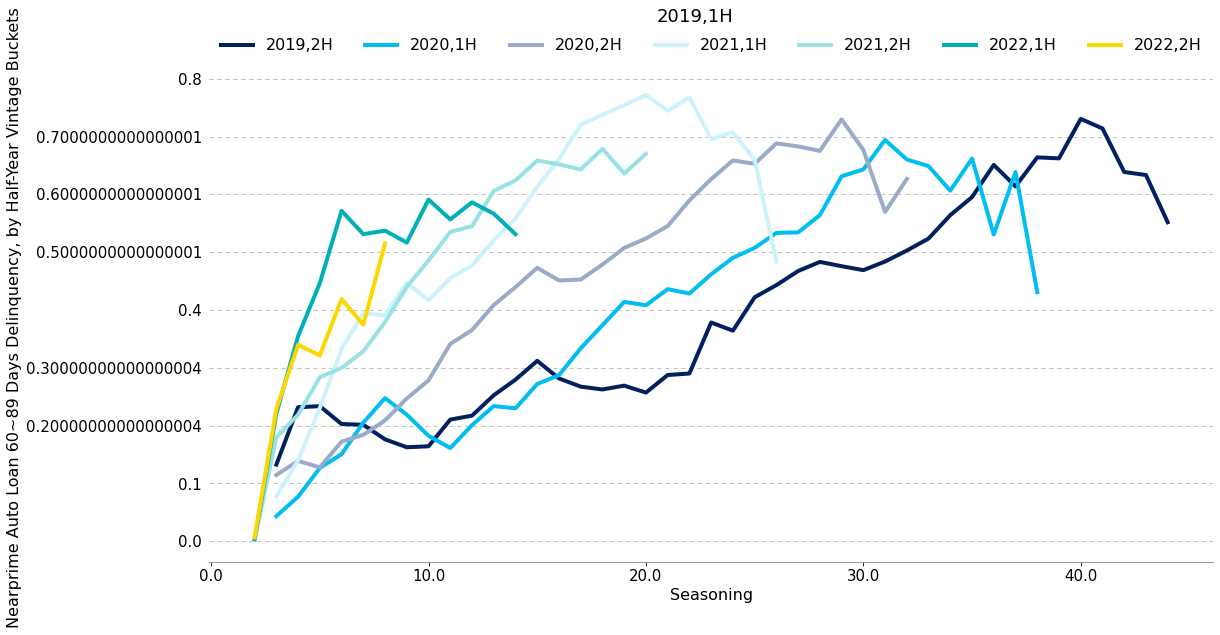

In [42]:
save_chart(
    plot_metric_fullhist_vintage_y2decimals(nearprime_DQ60to89_byvintage,'% of Ending Loan Balnace','Nearprime Auto Loan 60~89 Days Delinquency, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'DQ 60~89 by Vintage for FICO 660-720')

### Above 720 FICO, DQ 60~89 by Vintage

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


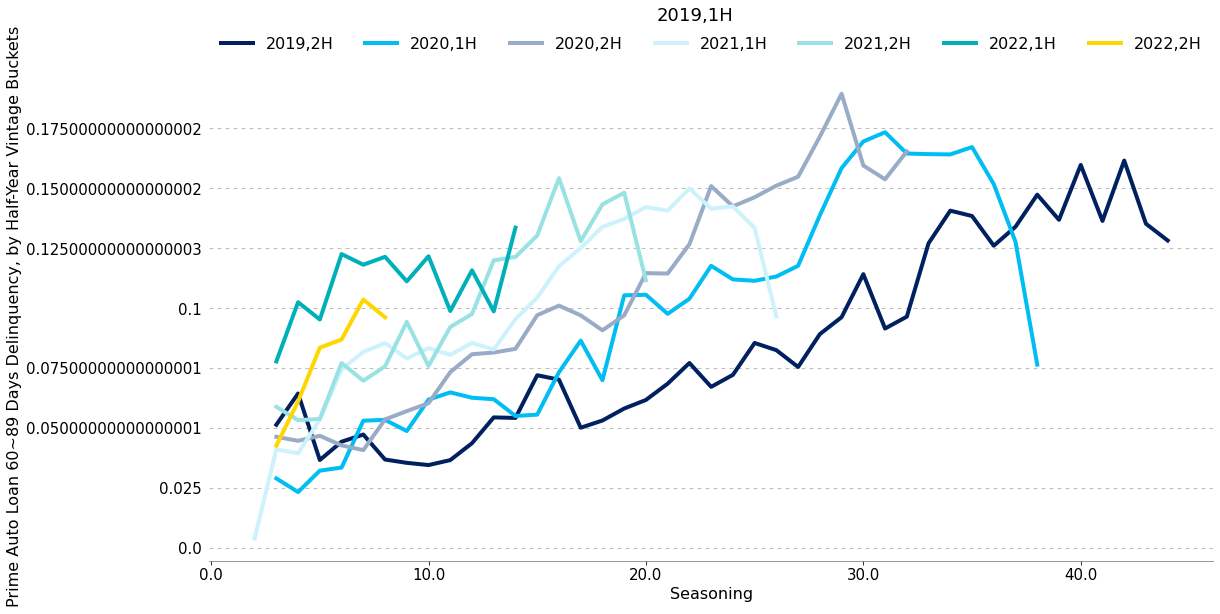

In [43]:
save_chart(
    plot_metric_fullhist_vintage_y2decimals(prime_DQ60to89_byvintage,'% of Ending Loan Balnace','Prime Auto Loan 60~89 Days Delinquency, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'DQ 60~89 by Vintage for FICO above 720')

### Below 660 FICO, DQ 90+

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


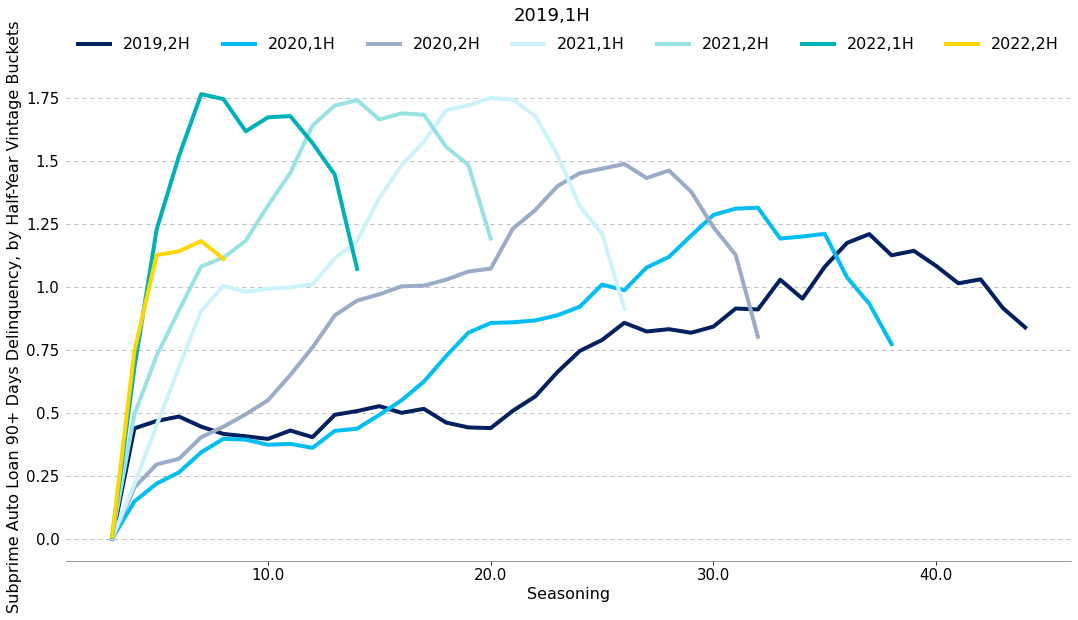

In [44]:
save_chart(
    plot_metric_fullhist_vintage_y2decimals(subprime_DQ90p_byvintage,'% of Ending Loan Balnace','Subprime Auto Loan 90+ Days Delinquency, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'DQ 90+ by Vintage for FICO below 660')

### 660-720 FICO, DQ 90+

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\3456018415.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


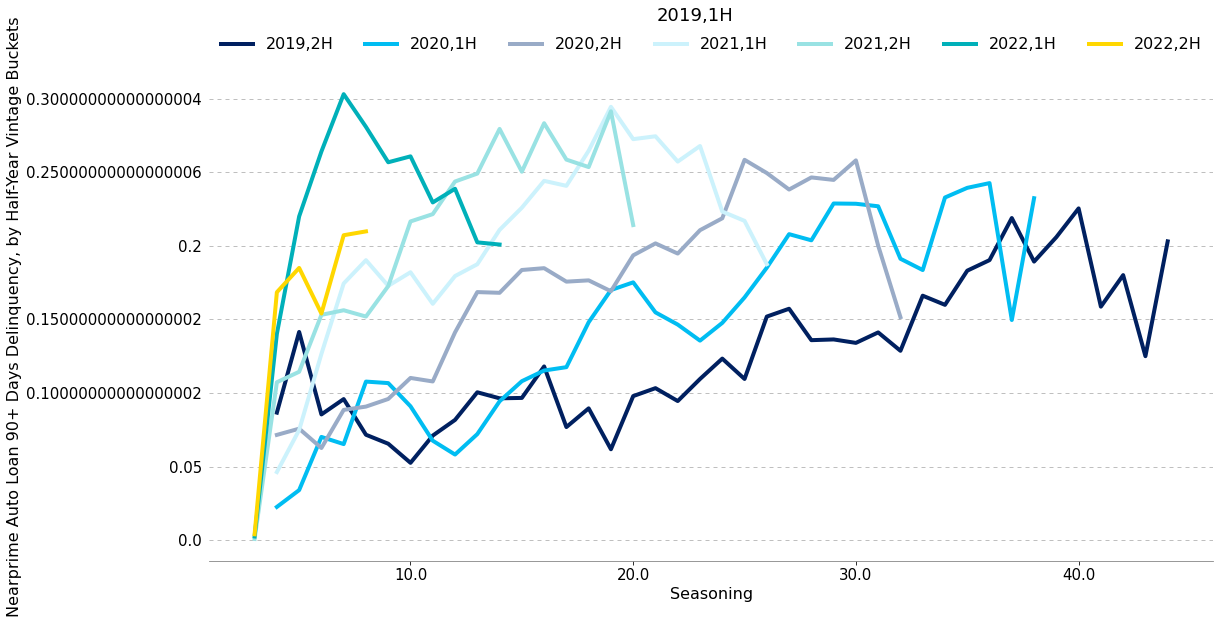

In [48]:
save_chart(
    plot_metric_fullhist_vintage_y2decimals(nearprime_DQ90p_byvintage,'% of Ending Loan Balnace','Nearprime Auto Loan 90+ Days Delinquency, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'DQ 90+ by Vintage for FICO 660-720')

## CDR of various FICO bucket, by Vintage

In [49]:
file = open('cdr_by Vintage.txt','r')
lines = file.readlines()
q = [line.rstrip().lstrip() for line in lines]
file.close()
q="".join(q)

print(q)

<base table="pub.fin.edgar.auto_loan.loan_detail"/><sel value="(credit_score>300)"/><willbe name="drop_record_flag" value="iff((zero_bal_code=NA) & (dq_status=NA);1;0)"/><note type="user"> Create a flag called drop_record which assigns a value of 1 to 1oan records whose zero_balance_code and dq_status are both blank,i.e.NA,andassign a value of 0 otherwise. </note><sel value="drop_record_flag=0"/><willbe name="fico_bucket" value="iff(credit_score<=660;'below 660';credit_score<=720; '660-720' ;credit_score<=800; 'above 720';'no fico')"/><willbe name="def_bal" value="if(zero_bal_code='4'&zero_bal_dt=fmonth;begin_bal;0)"/><willbe name="vintage_year" value="year(orig_dt)"/><willbe name="vintage_month" value="month(orig_dt)"/><willbe name="vintage_halfyr_denote" value="iff(vintage_month<=6;'1H' ;vintage_month>6; '2H'; 'n/a')"/><willbe name="vintage_bucket" value="colunion(vintage_year vintage_halfyr_denote;',')"/><willbe name="vintage_date_in_months" value="12*(vintage_year)+vintage_month"/>

In [50]:
cdr_byFICOvintage = Get_1010Data(q)

result saved as a dataframe, and 1010 session closed


In [51]:
pd.concat([cdr_byFICOvintage.head(10),cdr_byFICOvintage.tail(10)])

,seasoning,fico_bucket,vintage_bucket,begin_bal,def_bal
0,-1,660-720,"1H,2021",0.000000e+00,0.00
1,-1,660-720,"1H,2022",0.000000e+00,0.00
2,-1,660-720,"2021,2H",0.000000e+00,0.00
3,-1,660-720,"2022,2H",0.000000e+00,0.00
4,-1,above 720,"1H,2021",0.000000e+00,0.00
5,-1,above 720,"1H,2022",0.000000e+00,0.00
6,-1,above 720,"2021,2H",0.000000e+00,0.00
7,-1,above 720,"2022,2H",0.000000e+00,0.00
8,-1,below 660,"1H,2021",0.000000e+00,0.00
9,-1,below 660,"1H,2022",0.000000e+00,0.00


In [52]:
cdr_byFICOvintage['cdr'] = (1-(1-cdr_byFICOvintage['def_bal']/cdr_byFICOvintage['begin_bal'])**12)*100

In [53]:
cdr_byFICOvintage_pivot = pd.pivot_table(cdr_byFICOvintage,values=['cdr'],columns=['seasoning','fico_bucket','vintage_bucket'],aggfunc=[np.sum],dropna=True).transpose()

In [57]:
cdr_byFICOvintage_pivot.tail(20)

cdr
    seasoning fico_bucket vintage_bucket          
sum 46        660-720     1H,2019         2.152587
              above 720   1H,2019         0.435536
              below 660   1H,2019         9.089170
              no fico     1H,2019         0.208385
    47        660-720     1H,2019         2.789585
              above 720   1H,2019         0.652025
              below 660   1H,2019         8.801153
              no fico     1H,2019         0.088007
    48        660-720     1H,2019         1.925033
              above 720   1H,2019         0.703031
              below 660   1H,2019         8.144214
              no fico     1H,2019         0.053998
    49        660-720     1H,2019         2.434843
              above 720   1H,2019         0.362004
              below 660   1H,2019         9.502839
              no fico     1H,2019         0.128208
    50        660-720     1H,2019         2.253489
              above 720   1H,2019         0.303845
              below 660   1H,2019         7.053904
              no fico     1H,2019         0.000000

In [58]:
cdr_byFICOvintage_pivot = cdr_byFICOvintage_pivot.rename(index={'1H,2019':'2019,1H','1H,2020':'2020,1H','1H,2021': '2021,1H','1H,2022': '2022,1H'})

In [59]:
cdr_byFICOvintage_pivot=cdr_byFICOvintage_pivot[cdr_byFICOvintage_pivot!=0]

In [60]:
subprime_cdr_byvintage = filter_pivot(cdr_byFICOvintage_pivot,'fico_bucket == ["below 660"]').reset_index(level=['seasoning'])
nearprime_cdr_byvintage = filter_pivot(cdr_byFICOvintage_pivot,'fico_bucket == ["660-720"]').reset_index(level=['seasoning'])
prime_cdr_byvintage = filter_pivot(cdr_byFICOvintage_pivot,'fico_bucket == ["above 720"]').reset_index(level=['seasoning'])

### FICO below 660, CDR by Vintage

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2440077505.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2440077505.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


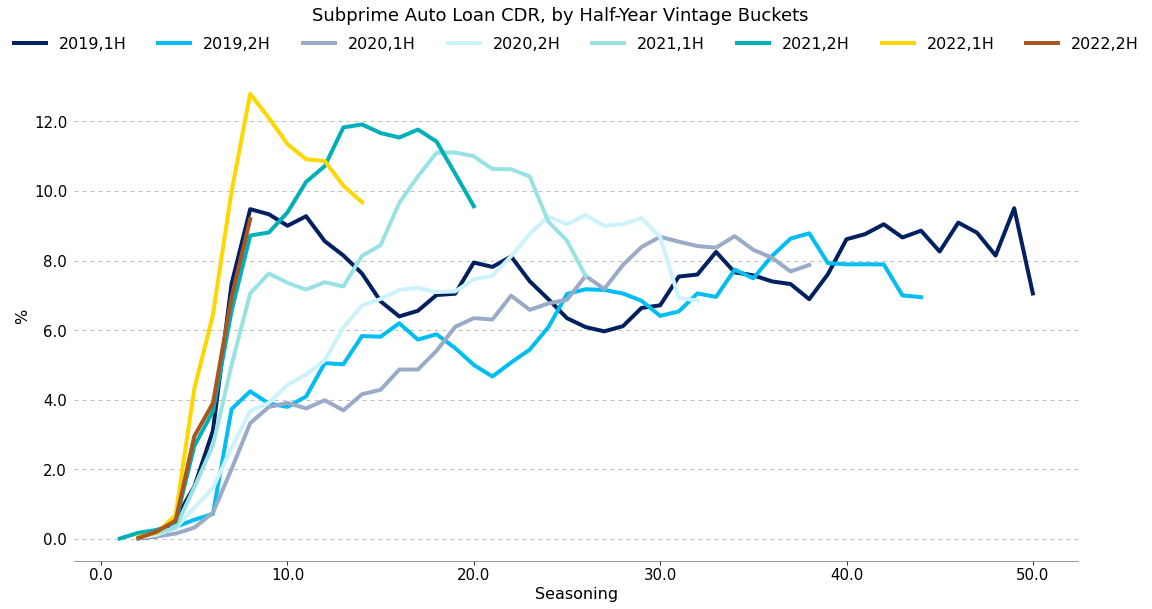

In [61]:
save_chart(
    plot_metric_fullhist_vintage(subprime_cdr_byvintage,'%','Subprime Auto Loan CDR, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'CDR by Vintage for FICO below 660')

### FICO 660 - 720, CDR by Vintage

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2440077505.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2440077505.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


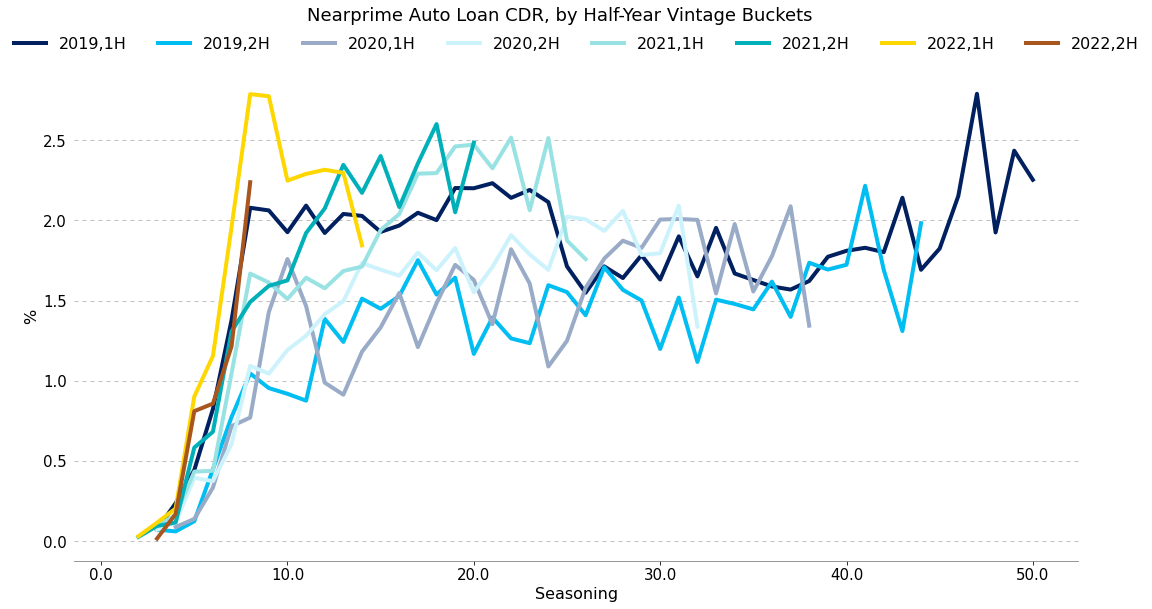

In [62]:
save_chart(
    plot_metric_fullhist_vintage(nearprime_cdr_byvintage,'%','Nearprime Auto Loan CDR, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'CDR by Vintage for FICO 660-720')

### FICO above 720, CDR by Vintage

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2440077505.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in ax.get_xticks()], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2440077505.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


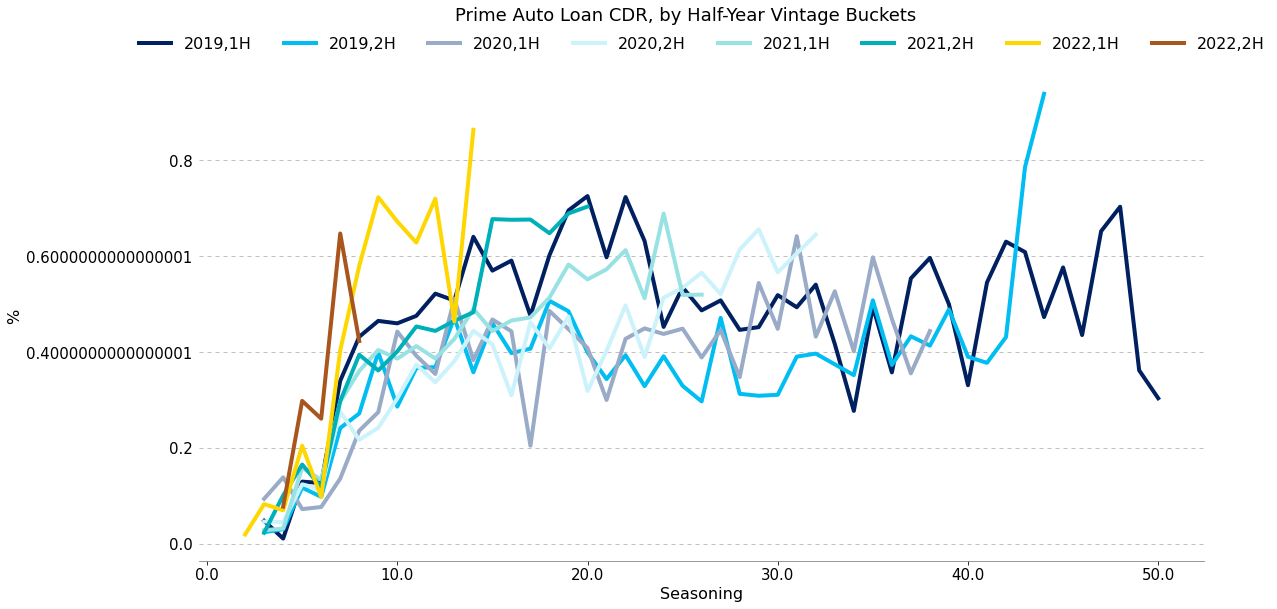

In [63]:
save_chart(
    plot_metric_fullhist_vintage(prime_cdr_byvintage,'%','Prime Auto Loan CDR, by Half-Year Vintage Buckets','2019,1H','2019,2H','2020,1H','2020,2H','2021,1H','2021,2H','2022,1H','2022,2H'),
    'CDR by Vintage for FICO above 720')

## Loan Cure Rates

In [85]:
file = open('Cure.txt','r')
lines = file.readlines()
q = [line.rstrip().lstrip() for line in lines]
file.close()
q="".join(q)

print(q)

<base table="pub.fin.edgar.auto_loan.loan_detail"/><sel value="(credit_score>300)"/><willbe name="drop_record_flag" value="iff((zero_bal_code=NA) & (dq_status=NA);1;0)"/><note type="user"> Create a flag called drop_record which assigns a value of 1 to 1oan records whose zero_balance_code and dq_status are both blank,i.e.NA,andassign a value of 0 otherwise. </note><sel value="drop_record_flag=0"/><willbe name="fico_bucket" value="iff(credit_score<=660;'below 660';credit_score<=720;'660-720';credit_score>720;'above 720';'no fico')"/><willbe name="is_dq" value="iff(dq_status>29;1;0)"/><willbe name="hasbeen_dq" value="g_cumhi(seqnum;;fmonth;is_dq)"/><willbe name="hasbeen_cure_temp" value="iff(dq_status=0 & hasbeen_dq=1;1;0)"/><willbe name="cure_flag" value="g_cumhi(seqnum;;fmonth;hasbeen_cure_temp)"/><sel value="dq_status=0"/><tabu breaks="fmonth,fico_bucket,cure_flag"><tcol fun="sum" name="end_bal" label="end_bal_sum" source="end_bal"/></tabu><sort cols="fmonth,fico_bucket,cure_flag"/>


In [86]:
cure_hist_byFICO = Get_1010Data(q)

result saved as a dataframe, and 1010 session closed


In [93]:
cure_hist_byFICO = datetime_convert(cure_hist_byFICO)
cure_hist_byFICO.tail(20)

,fmonth,fico_bucket,cure_flag,end_bal
433,2022-12-01,below 660,0,2.294792e+10
434,2022-12-01,below 660,1,2.248661e+09
435,2023-01-01,660-720,0,1.864720e+10
436,2023-01-01,660-720,1,4.771894e+08
437,2023-01-01,above 720,0,5.732341e+10
438,2023-01-01,above 720,1,3.463342e+08
439,2023-01-01,below 660,0,2.364670e+10
440,2023-01-01,below 660,1,2.471310e+09
441,2023-02-01,660-720,0,1.911896e+10
442,2023-02-01,660-720,1,5.323855e+08


In [94]:
cure_byFICO_pivot = Get_cure_pivot(cure_hist_byFICO)

In [96]:
pd.concat([cure_byFICO_pivot.head(10),cure_byFICO_pivot.tail(10)])

cure_percent
    fmonth     fico_bucket cure_flag              
sum 2016-12-01 660-720     0            100.000000
                           1              0.000000
               above 720   0            100.000000
                           1              0.000000
               below 660   0            100.000000
                           1              0.000000
    2017-01-01 660-720     0             99.970341
                           1              0.029659
               above 720   0             99.997231
                           1              0.002769
    2023-02-01 above 720   0             99.399228
                           1              0.600772
               below 660   0             88.407234
                           1             11.592766
    2023-03-01 660-720     0             97.139905
                           1              2.860095
               above 720   0             99.351642
                           1              0.648358
               below 660   0             88.372220
                           1             11.627780

In [97]:
is_cure_pivot = cure_byFICO_pivot.query('cure_flag == [1]')
is_cure_pivot=is_cure_pivot.reset_index(level=['fmonth'])

In [99]:
pd.concat([is_cure_pivot.head(9),is_cure_pivot.tail(9)])

fmonth  cure_percent
    fico_bucket cure_flag                         
sum 660-720     1         2016-12-01      0.000000
    above 720   1         2016-12-01      0.000000
    below 660   1         2016-12-01      0.000000
    660-720     1         2017-01-01      0.029659
    above 720   1         2017-01-01      0.002769
    below 660   1         2017-01-01      0.102203
    660-720     1         2017-02-01      0.093386
    above 720   1         2017-02-01      0.016664
    below 660   1         2017-02-01      0.518865
    660-720     1         2023-01-01      2.495187
    above 720   1         2023-01-01      0.600547
    below 660   1         2023-01-01      9.462093
    660-720     1         2023-02-01      2.709156
    above 720   1         2023-02-01      0.600772
    below 660   1         2023-02-01     11.592766
    660-720     1         2023-03-01      2.860095
    above 720   1         2023-03-01      0.648358
    below 660   1         2023-03-01     11.627780

## Loan Modification

In [64]:
file = open('Mods.txt','r')
lines = file.readlines()
q = [line.rstrip().lstrip() for line in lines]
file.close()
q="".join(q)

print(q)

<base table="pub.fin.edgar.auto_loan.loan_detail"/><sel value="(credit_score>300)"/><willbe name="drop_record_flag" value="iff((zero_bal_code=NA) & (dq_status=NA);1;0)"/><note type="user"> Create a flag called drop_record which assigns a value of 1 to 1oan records whose zero_balance_code and dq_status are both blank,i.e.NA,andassign a value of 0 otherwise. </note><sel value="drop_record_flag=0"/><willbe name="fico_bucket" value="iff(credit_score<=660;'below 660';credit_score<=720;'660-720';credit_score>720;'above 720';'no fico')"/><note type="user"> We have tested that dq_status being empty does not carry anynotional.</note><willbe name="mod_flag" value="iff(mod_type_code='';0;1)"/><tabu breaks="fmonth,fico_bucket,mod_flag"><tcol fun="sum" name="end_bal_sum" label="end_bal_sum" source="end_bal"/></tabu><sort cols="fmonth,fico_bucket,mod_flag"/>


In [65]:
mods_hist_byFICO = Get_1010Data(q)

result saved as a dataframe, and 1010 session closed


In [66]:
mods_hist_byFICO = datetime_convert(mods_hist_byFICO)
mods_hist_byFICO.tail(20)

,fmonth,fico_bucket,mod_flag,end_bal_sum
436,2022-12-01,below 660,0,3.839468e+10
437,2022-12-01,below 660,1,1.166295e+09
438,2023-01-01,660-720,0,2.161032e+10
439,2023-01-01,660-720,1,2.133950e+08
440,2023-01-01,above 720,0,5.936798e+10
441,2023-01-01,above 720,1,1.321758e+08
442,2023-01-01,below 660,0,3.943956e+10
443,2023-01-01,below 660,1,1.057243e+09
444,2023-02-01,660-720,0,2.226597e+10
445,2023-02-01,660-720,1,1.790050e+08


In [70]:
mods_byFICO_pivot = Get_mods_pivot(mods_hist_byFICO)

In [71]:
is_mod_pivot = mods_byFICO_pivot.query('mod_flag == [1]')
is_mod_pivot = is_mod_pivot.reset_index(level=['fmonth'])

In [72]:
pd.concat([is_mod_pivot.head(9),is_mod_pivot.tail(9)])

fmonth  mod_percent
    fico_bucket mod_flag                        
sum 660-720     1        2016-12-01     0.510838
    above 720   1        2016-12-01     0.135799
    below 660   1        2016-12-01     0.848361
    660-720     1        2017-01-01     1.454257
    above 720   1        2017-01-01     0.329613
    below 660   1        2017-01-01     4.958326
    660-720     1        2017-02-01     0.617670
    above 720   1        2017-02-01     0.154601
    below 660   1        2017-02-01     1.238234
    660-720     1        2023-01-01     0.977813
    above 720   1        2023-01-01     0.222144
    below 660   1        2023-01-01     2.610683
    660-720     1        2023-02-01     0.797528
    above 720   1        2023-02-01     0.174570
    below 660   1        2023-02-01     2.347314
    660-720     1        2023-03-01     0.810415
    above 720   1        2023-03-01     0.186885
    below 660   1        2023-03-01     1.953389

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2693944589.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in metric_df['fmonth'].values], fontsize=15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2693944589.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


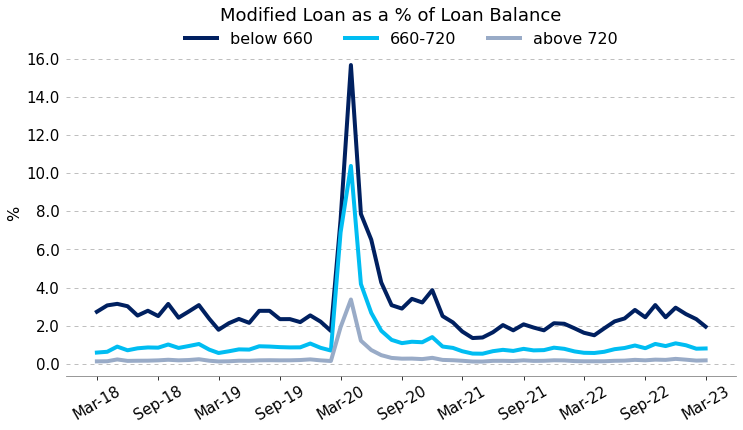

chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


In [77]:
save_chart(
    plot_metric_fullhist(is_mod_pivot,start_date,'%',"Modified Loan as a % of Loan Balance",'below 660','660-720','above 720'),
    'Mods_byFICO'
)

In [78]:
file = open('Mods joint Cure.txt','r')
lines = file.readlines()
q = [line.rstrip().lstrip() for line in lines]
file.close()
q="".join(q)

print(q)

<base table="pub.fin.edgar.auto_loan.loan_detail"/><sel value="(credit_score>300)"/><willbe name="drop_record_flag" value="iff((zero_bal_code=NA) & (dq_status=NA);1;0)"/><note type="user">Create a flag called drop_record which assigns a value of 1 toloan records whose zero_balance_code and dq_status are both blank, i.e. NA,and assign a value of Î¸ otherwise.</note><sel value="drop_record_flag=0"/><willbe name="fico_bucket" value="iff(credit_score<=660;'below 660';credit_score<=720;'660-720';credit_score>720;'above 720';'no fico')"/><willbe name="is_dq" value="iff(dq_status>29;1;0)"/><willbe name="hasbeen_dq" value="g_cumhi(seqnum;;fmonth;is_dq)"/><willbe name="hasbeen_cure_temp" value="g_cumhi(seqnum;;fmonth;is_dq)"/><willbe name="cure_flag" value="g_cumhi(seqnum;;fmonth;hasbeen_cure_temp)"/><willbe name="mod_flag" value="iff(mod_type_code='';0;1)"/><willbe name="mod_joint_cure_flag" value="if(mod_flag=1 & cure_flag=1;1;0)"/><sel value="dq_status=0"/><tabu breaks="fmonth,fico_bucket,mo

In [79]:
cure_overlap_mods_hist = Get_1010Data(q)

result saved as a dataframe, and 1010 session closed


In [80]:
cure_overlap_mods_hist = datetime_convert(cure_overlap_mods_hist)

pd.concat([cure_overlap_mods_hist.head(10),cure_overlap_mods_hist.tail(10)])

,fmonth,fico_bucket,mod_joint_cure_flag,end_bal_sum
0,2016-12-01,660-720,0,1.030135e+09
1,2016-12-01,above 720,0,1.839140e+09
2,2016-12-01,below 660,0,1.539641e+09
3,2017-01-01,660-720,0,1.597921e+09
4,2017-01-01,660-720,1,1.172112e+05
5,2017-01-01,above 720,0,3.045996e+09
6,2017-01-01,below 660,0,2.445611e+09
7,2017-01-01,below 660,1,7.390624e+05
8,2017-02-01,660-720,0,2.654037e+09
9,2017-02-01,660-720,1,5.183691e+05


In [81]:
curemods_byfico_pivot = Get_cure_overlapmods_pivot(cure_overlap_mods_hist)

In [82]:
pd.concat([curemods_byfico_pivot.head(18),curemods_byfico_pivot.tail(18)])

curemods_percent
    fmonth     fico_bucket mod_joint_cure_flag                  
sum 2016-12-01 660-720     0                          100.000000
                           1                            0.000000
               above 720   0                          100.000000
                           1                            0.000000
               below 660   0                          100.000000
                           1                            0.000000
    2017-01-01 660-720     0                           99.992665
                           1                            0.007335
               above 720   0                          100.000000
                           1                            0.000000
               below 660   0                           99.969789
                           1                            0.030211
    2017-02-01 660-720     0                           99.980472
                           1                            0.019528
               above 720   0                           99.997548
                           1                            0.002452
               below 660   0                           99.925379
                           1                            0.074621
    2023-01-01 660-720     0                           99.805375
                           1                            0.194625
               above 720   0                           99.973938
                           1                            0.026062
               below 660   0                           98.667308
                           1                            1.332692
    2023-02-01 660-720     0                           99.830205
                           1                            0.169795
               above 720   0                           99.977802
                           1                            0.022198
               below 660   0                           98.776163
                           1                            1.223837
    2023-03-01 660-720     0                           99.821416
                           1                            0.178584
               above 720   0                           99.976082
                           1                            0.023918
               below 660   0                           98.934322
                           1                            1.065678

In [83]:
is_curemods_pivot = curemods_byfico_pivot.query('mod_joint_cure_flag == [1]')

In [84]:
is_curemods_pivot = is_curemods_pivot.reset_index(level=['fmonth'])

### Subprime Curemods

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2227056811.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([str(i) for i in is_cure_pivot['fmonth'].xs('below 660',level='fico_bucket').values], fontsize=16)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2227056811.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([str(i) for i in ax1.get_yticks()],fontsize=16)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2227056811.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([str(i) for i in is_curemods_pivot['fmonth'].xs('below 660',level='fico_bucket').values], fontsize=16)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\2227056811.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(i) for i in ax2.get_yticks()],fontsize=16)


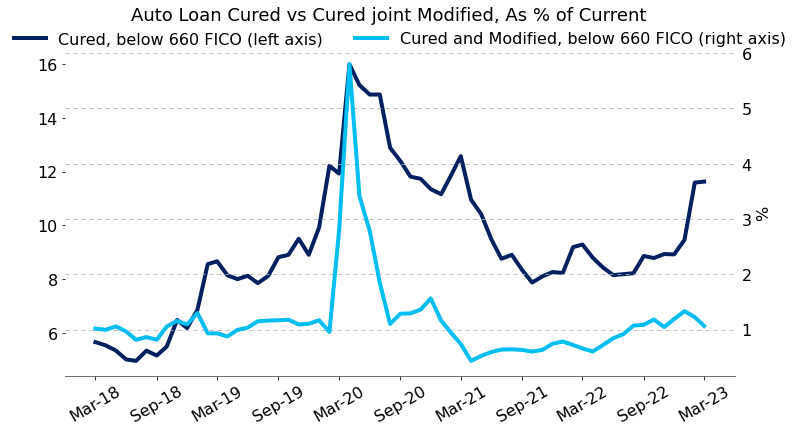

In [116]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

c = ['#002060','#00BDF2','#99ABC7','#CCF2FC','99E2E3','#00B0B9','#FFD700','#A9561E','#E6DAA6']

ax1.plot(is_cure_pivot.loc[is_cure_pivot['fmonth']>=start_date].xs('below 660',level='fico_bucket')['fmonth'],
         is_cure_pivot.loc[is_cure_pivot['fmonth']>=start_date].xs('below 660',level='fico_bucket')['cure_percent'],
         c=c[0], ls='-', label = "Cured, below 660 FICO (left axis)", fillstyle ='none', linewidth = 4.0)

plt.xticks(rotation=30)

ax1.set_xticklabels([str(i) for i in is_cure_pivot['fmonth'].xs('below 660',level='fico_bucket').values], fontsize=16)
ax1.set_yticklabels([str(i) for i in ax1.get_yticks()],fontsize=16)

ax1.tick_params(axis='x',colors='black')
ax1.tick_params(axis='y', colors='black')

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.yaxis.set_ticks_position('none')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # no decimal place for y-ticks

# plot second axis
ax2 = ax1.twinx()

ax2.plot(is_curemods_pivot.loc[is_curemods_pivot['fmonth']>=start_date].xs('below 660',level='fico_bucket')['fmonth'],
         is_curemods_pivot.loc[is_curemods_pivot['fmonth']>=start_date].xs('below 660',level='fico_bucket')['curemods_percent'],
         c=c[1], ls='-', label = "Cured and Modified, below 660 FICO (right axis)", fillstyle ='none', linewidth = 4.0)

ax2.set_xticklabels([str(i) for i in is_curemods_pivot['fmonth'].xs('below 660',level='fico_bucket').values], fontsize=16)
ax2.set_yticklabels([str(i) for i in ax2.get_yticks()],fontsize=16)

ax2.tick_params(axis='x',colors='black')
ax2.tick_params(axis='y', colors='black')

ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.yaxis.set_ticks_position('none')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3,9)))

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

ax2.grid(axis='y',linestyle='--',dashes=(5,5))

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) # no decimal place for y-ticks

# generate legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 'upper center', ncol = 2, prop = {'size':16},bbox_to_anchor=(0.5,1.1),fancybox=True,frameon=False)

plt.ylabel("%", fontsize = 16)
plt.gca().spines['bottom'].set_color('grey')

fig.suptitle('Auto Loan Cured vs Cured joint Modified, As % of Current', fontsize = 18)

plt.show()

In [117]:
save_chart(
    fig,
    'Curemods_subprime'
)

chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output


### Nearprime Curemods

C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\64806373.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([str(i) for i in is_cure_pivot['fmonth'].xs('660-720',level='fico_bucket').values], fontsize=16)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\64806373.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([str(i) for i in ax1.get_yticks()],fontsize=16)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\64806373.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([str(i) for i in is_curemods_pivot['fmonth'].xs('660-720',level='fico_bucket').values], fontsize=16)
C:\Users\zihao\AppData\Local\Temp\ipykernel_101828\64806373.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(i) for i in ax2.get_yticks()],fontsize=16)


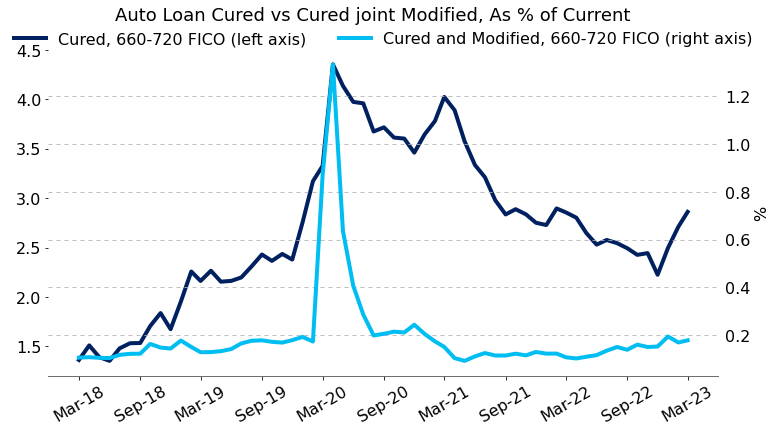

In [114]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

c = ['#002060','#00BDF2','#99ABC7','#CCF2FC','99E2E3','#00B0B9','#FFD700','#A9561E','#E6DAA6']

ax1.plot(is_cure_pivot.loc[is_cure_pivot['fmonth']>=start_date].xs('660-720',level='fico_bucket')['fmonth'],
         is_cure_pivot.loc[is_cure_pivot['fmonth']>=start_date].xs('660-720',level='fico_bucket')['cure_percent'],
         c=c[0], ls='-', label = "Cured, 660-720 FICO (left axis)", fillstyle ='none', linewidth = 4.0)

plt.xticks(rotation=30)

ax1.set_xticklabels([str(i) for i in is_cure_pivot['fmonth'].xs('660-720',level='fico_bucket').values], fontsize=16)
ax1.set_yticklabels([str(i) for i in ax1.get_yticks()],fontsize=16)

ax1.tick_params(axis='x',colors='black')
ax1.tick_params(axis='y', colors='black')

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.yaxis.set_ticks_position('none')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}')) # no decimal place for y-ticks

# plot second axis
ax2 = ax1.twinx()

ax2.plot(is_curemods_pivot.loc[is_curemods_pivot['fmonth']>=start_date].xs('660-720',level='fico_bucket')['fmonth'],
         is_curemods_pivot.loc[is_curemods_pivot['fmonth']>=start_date].xs('660-720',level='fico_bucket')['curemods_percent'],
         c=c[1], ls='-', label = "Cured and Modified, 660-720 FICO (right axis)", fillstyle ='none', linewidth = 4.0)

ax2.set_xticklabels([str(i) for i in is_curemods_pivot['fmonth'].xs('660-720',level='fico_bucket').values], fontsize=16)
ax2.set_yticklabels([str(i) for i in ax2.get_yticks()],fontsize=16)

ax2.tick_params(axis='x',colors='black')
ax2.tick_params(axis='y', colors='black')

ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.yaxis.set_ticks_position('none')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(3,9)))

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%b-%y"))

ax2.grid(axis='y',linestyle='--',dashes=(5,5))

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}')) # no decimal place for y-ticks

# generate legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 'upper center', ncol = 2, prop = {'size':16},bbox_to_anchor=(0.5,1.1),fancybox=True,frameon=False)

plt.ylabel("%", fontsize = 16)
plt.gca().spines['bottom'].set_color('grey')

fig.suptitle('Auto Loan Cured vs Cured joint Modified, As % of Current', fontsize = 18)

plt.show()

In [115]:
save_chart(
    fig,
    'Curemods_nearprime'
)

chart saved to the target and BACKUP directory in this following directory C:\Users\zihao\Desktop\Citi Work\ABS Research\Auto Perf Output
